In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

#from bokeh.plotting import figure, show, output_notebook
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use("ggplot") # Set plot style
%matplotlib inline

In [2]:
df = pd.read_csv(r"C:\Users\denil\OneDrive\Documents\PJME_hourly.csv")

In [3]:
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [4]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

#Date features
df["Hour"] = df["Datetime"].dt.hour
df["Day"] = df["Datetime"].dt.dayofweek
df["Month"] = df["Datetime"].dt.month
df["Year"] = df["Datetime"].dt.year
df["Q"] = df["Datetime"].dt.quarter
df["Dayofyear"] = df["Datetime"].dt.dayofyear
df["Dayofmonth"] = df["Datetime"].dt.day
df["Weekofyear"] = df["Datetime"].dt.weekofyear

df["Drop_me"] = df["Datetime"].dt.strftime("%m-%d")

df.index = df["Datetime"]
df = df.drop(["Datetime"],axis=1)

C:\Users\denil\AppData\Local\Temp\ipykernel_34972\3486507697.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["Datetime"].dt.weekofyear


Text(0.0, 1.0, 'Consumption distribution')

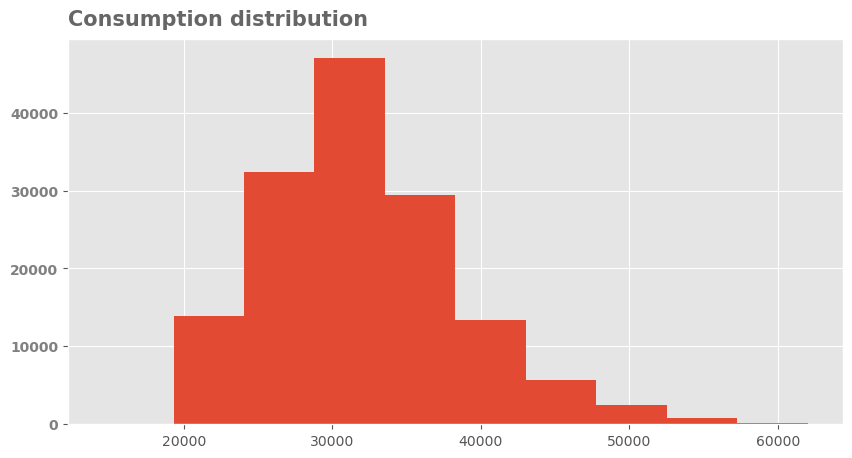

In [5]:
ax, fig = plt.subplots(figsize=(10,5))

plt.hist(df["PJME_MW"])

plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("",alpha=0.75, weight="bold")
plt.ylabel("",alpha=0.75, weight="bold")

plt.title("Consumption distribution", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

The distribution plot is slightly left-skewed, with the majority of the consumption moving around the 30-35k range.

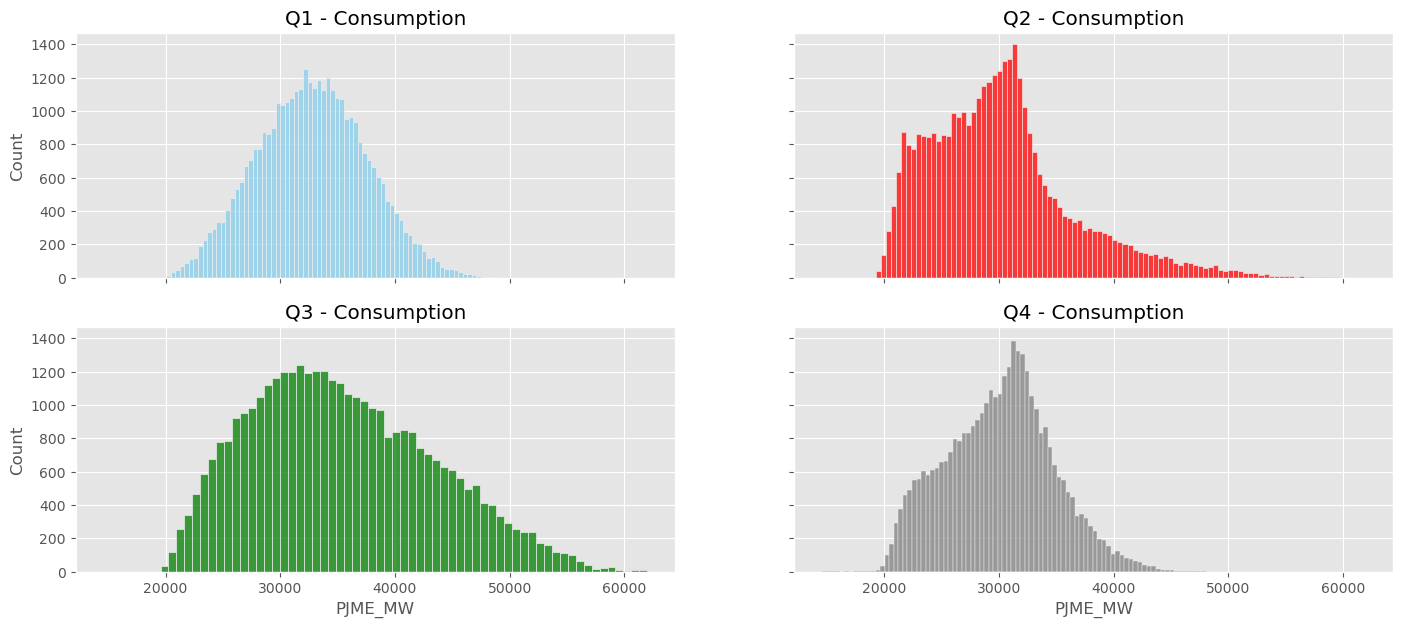

In [6]:
# Data prep
Q1 = df[df["Q"] == 1]
Q2 = df[df["Q"] == 2]
Q3 = df[df["Q"] == 3]
Q4 = df[df["Q"] == 4]

# Plot
fig, axes = plt.subplots(2, 2, figsize=(17, 7), sharex=True, sharey=True)

sns.histplot(Q1["PJME_MW"], color="skyblue", ax=axes[0, 0]).set_title("Q1 - Consumption")
sns.histplot(Q2["PJME_MW"], color="red", ax=axes[0, 1]).set_title("Q2 - Consumption")
sns.histplot(Q3["PJME_MW"], color="green", ax=axes[1, 0]).set_title("Q3 - Consumption")
sns.histplot(Q4["PJME_MW"], color="gray", ax=axes[1, 1]).set_title("Q4 - Consumption")

# Remove the variables Q1, Q2, Q3, Q4
del Q1, Q2, Q3, Q4


There are some major differences in the consumption distribution per quarter. This might be due to several factors, the most obvious being seasonal demand changes. Another major factor is the general temperature in the area. Higher temperatures encourage more electricity usage as office buildings and homes require cooling.

Text(0.0, 1.0, 'Mean daily consumption')

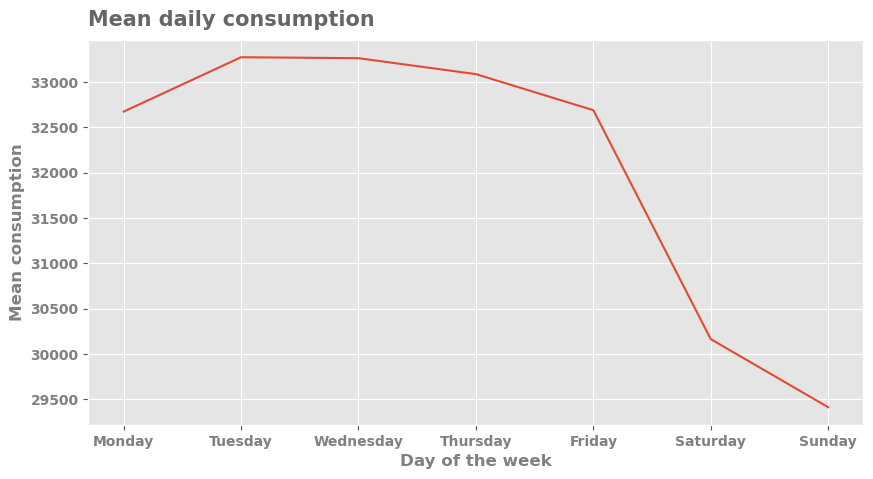

In [7]:
#Data prep
mean_per_day = df.groupby("Day")["PJME_MW"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))


plt.plot(mean_per_day.index,mean_per_day["mean"])

plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean daily consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

#del mean_per_day


The plot above showcases the cumulative consumption per day. We can very clearly see that days matter when it comes to consumption. The lowest usage is usually marked on the weekends as most commercial and industrial areas stay closed reducing the overall consumption of the area.


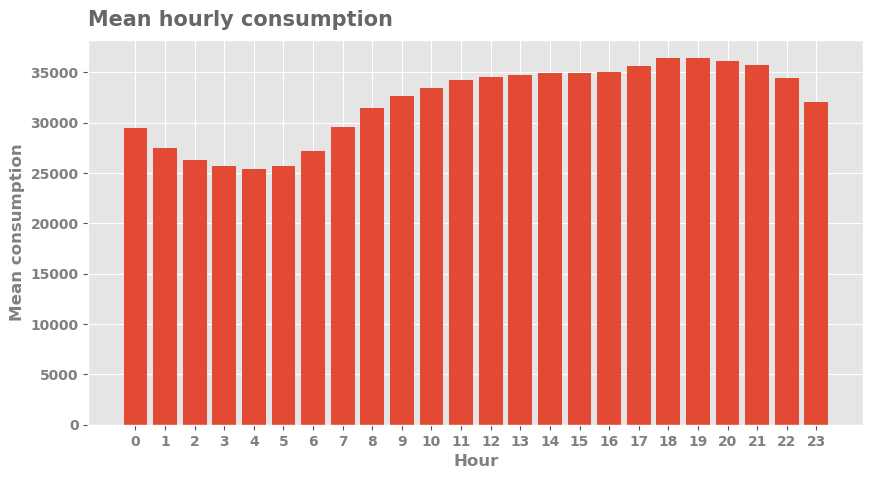

In [8]:
#Data
mean_per_hour = df.groupby("Hour")["PJME_MW"].agg(["mean"])

#Plot
fig, ax = plt.subplots(figsize=(10,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")

plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean consumption",alpha=0.75, weight="bold")

plt.title("Mean hourly consumption", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10)

del mean_per_hour

Looking at hourly consumption we can clearly see the peak and off-peak hours of the area.

Text(0.0, 1.0, 'Consumption over time')

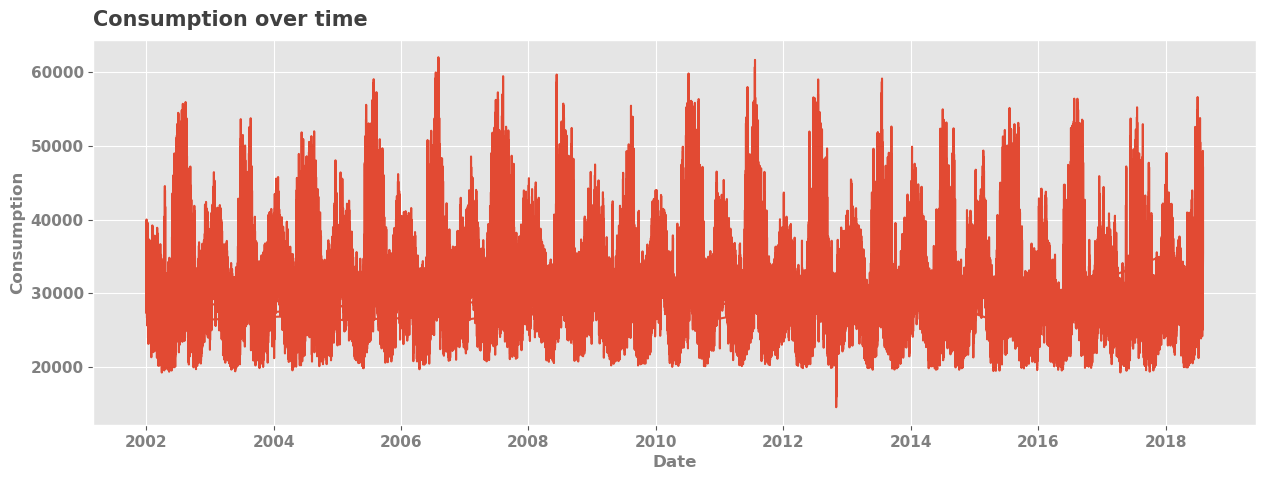

In [9]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(df.index,df["PJME_MW"])

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Consumption over time", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

Looking at the consumption data as a whole we can very clearly see a pattern with peaks and valleys. While the baseline consumption stayed pretty much the sam on around 20.000.

**Feature engineering - Part I**

During the second part, we will add columns that will help train the model and help it predict future consumption.

The categorical features added are:

  1.Holidays - I included some more famous American holidays.

  2.Worktime - If the half-hourly consumption demand happened during the usual worktime of most companies.

  3.Peak/Off-Peak - I diverted this feature from the EDA above.

  4.Weekend/NonWeekend - If the day is a working day or not. I am aware that this might be duplicating information as we have other columns that that indicate the exact day, but I would nonetheless like to cover all my bases.

The numerical features:

  1.Lag Variables - a shift in the data. I will explain more about this when we reach the cell.

  2.Temperature data (not included) - I initially wanted to include the average temperature for each day. Unfortunately, this is an RTO and as the name implies it covers multiple regions/states so getting and implementing good data was too difficult for now.

In [10]:

def feature_holidays(row):

    if row["Drop_me"] == "01-01":
        return "New Year"
    if row["Drop_me"] == "04-07":
        return "Ind Day"
    if row["Drop_me"] == "11-28":
        return "Thanksgiving"
    if row["Drop_me"] == "12-25":
        return "Christmas"
    return 'Other'
def feature_worktime(row):
    if row["Hour"] > 7 & row["Hour"] <= 17:
        return "Worktime"
    return "NonWorkTime"
def feature_peak(row):
    if row["Hour"] > 7 & row["Hour"] <= 22:
        return "Peak"
    return "NonPeak"
def feature_weekend(row):
    if row["Day"] == 5 or row["Day"] == 6:
        return "Weekend"
    return "NonWeekend"

In [11]:
df["Holiday"] = df.apply (lambda row : feature_holidays(row), axis=1)
df["Work"] = df.apply(lambda row: feature_worktime(row), axis=1)
df["Peak"] = df.apply(lambda row: feature_peak(row), axis=1)
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

In [12]:
df = df.drop(["Drop_me"],axis=1)

In [13]:
dummies = pd.get_dummies(df[["Holiday","Peak","Work","Weekend"]],prefix="Dummy")
df = df.join(dummies,lsuffix="_left")
df = df.drop(df[["Holiday","Peak","Work","Weekend"]], axis=1)

Below we are separating the dataset based on a date.

In [14]:
train_test_date = "01-01-2015"
consum_test = df[df.index > train_test_date].copy()
consum_train = df[df.index <= train_test_date].copy()

Lag variables are a classic approach to solving supervised regression problems on a time series dataset. The logic behind it is very simple, it uses the last variable to predict the next one. This adds additional features to the dataset and is usually very helpful.

There is, unfortunately, a downside to using Lag variables. They produce some NA values in the columns where the data is not available forcing us to drop them. This can severely reduce the number of rows we have for the training and testing of the algorithm.

In [15]:
def lag_features(lag_dataset,period_list):

    temp_data = lag_dataset["PJME_MW"]

    for period in period_list:

        lag_dataset["lag_consumption_{}".format(period)] = temp_data.shift(period)
        lag_dataset["mean_rolling_{}".format(period)] = temp_data.rolling(period).mean()
        lag_dataset["max_rolling_{}".format(period)] = temp_data.rolling(period).max()
        lag_dataset["min_rolling_{}".format(period)] = temp_data.rolling(period).min()

    for column in lag_dataset.columns[20:]:

        lag_dataset[column] = lag_dataset[column].fillna(lag_dataset.groupby("Hour")["PJME_MW"].transform("mean"))
    
    return lag_dataset

In [16]:
consum_train = lag_features(consum_train,[7,14,30])

consum_test = lag_features(consum_test,[7,14,30])

Text(0.0, 1.0, 'Train - Test Split')

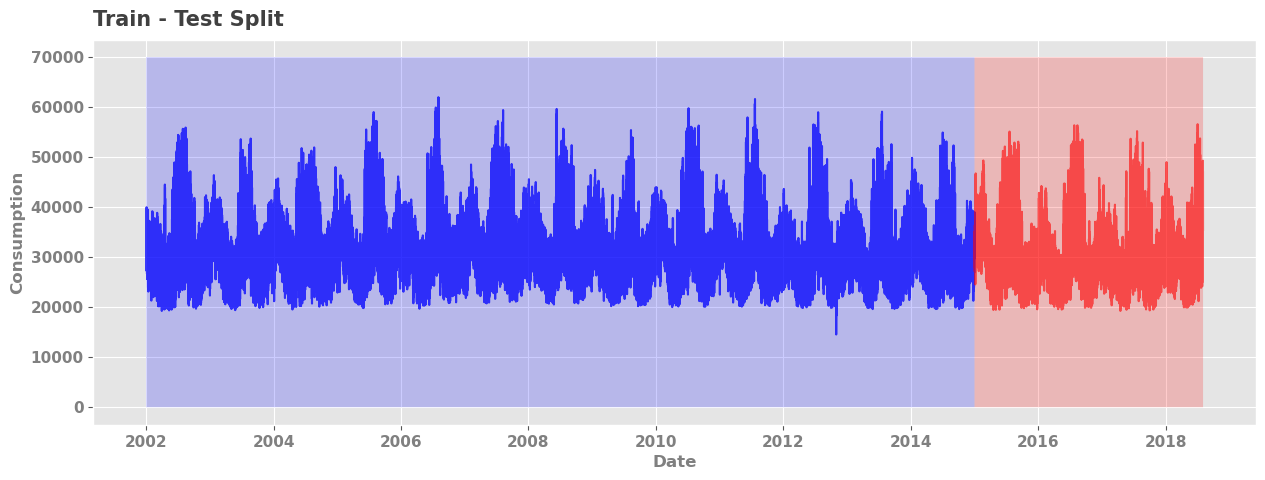

In [17]:
fig,ax = plt.subplots(figsize=(15,5))

coloring = 70000

plt.plot(consum_train.index,consum_train["PJME_MW"],color="blue", alpha=0.75)
plt.fill_between(consum_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(consum_test.index,consum_test["PJME_MW"], color = "red", alpha=0.60)
plt.fill_between(consum_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [18]:
#Train - Test
X_train = consum_train.drop("PJME_MW", axis=1) 
y_train = consum_train["PJME_MW"]
X_test = consum_test.drop("PJME_MW", axis=1)
y_test = consum_test["PJME_MW"]

In [19]:
#XGBoost

xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=False)


C:\Users\denil\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

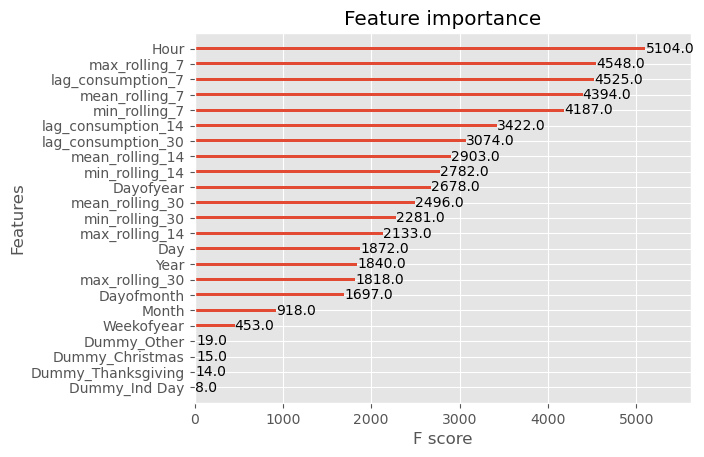

In [20]:
plot_importance(xgd_reg)

The plot importance option of XGBoost allows us to evaluate what features are good if we would like to use this algorithm in an automated pipeline or for any future use. In this instance, the F-score represents a simple metric that measures how many times the feature was used during the tree splitting.

In [21]:
consum_test["Prediction"] = xgd_reg.predict(X_test)

Text(0.0, 1.0, 'Predicted consumption')

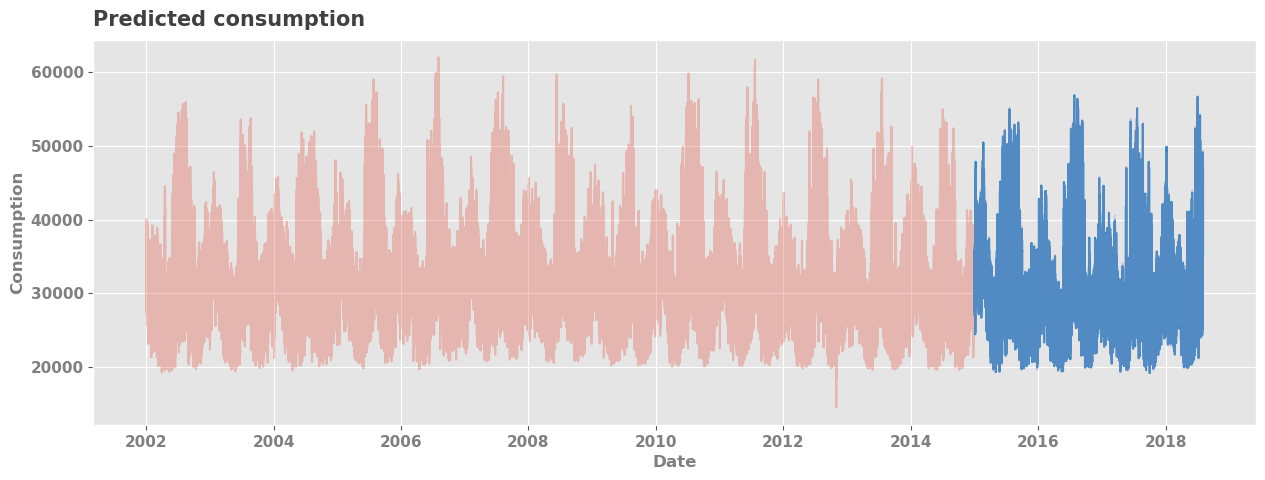

In [22]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(consum_train.index,consum_train["PJME_MW"],alpha=.3)
plt.plot(consum_test.index,consum_test["Prediction"])
plt.plot(consum_test.index,consum_test["PJME_MW"],alpha=.3)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

The predicted value covers most of the actual value on the plot. This can either be very good or very bad. We need to inquire further.

Text(0.0, 1.0, 'Predicted consumption')

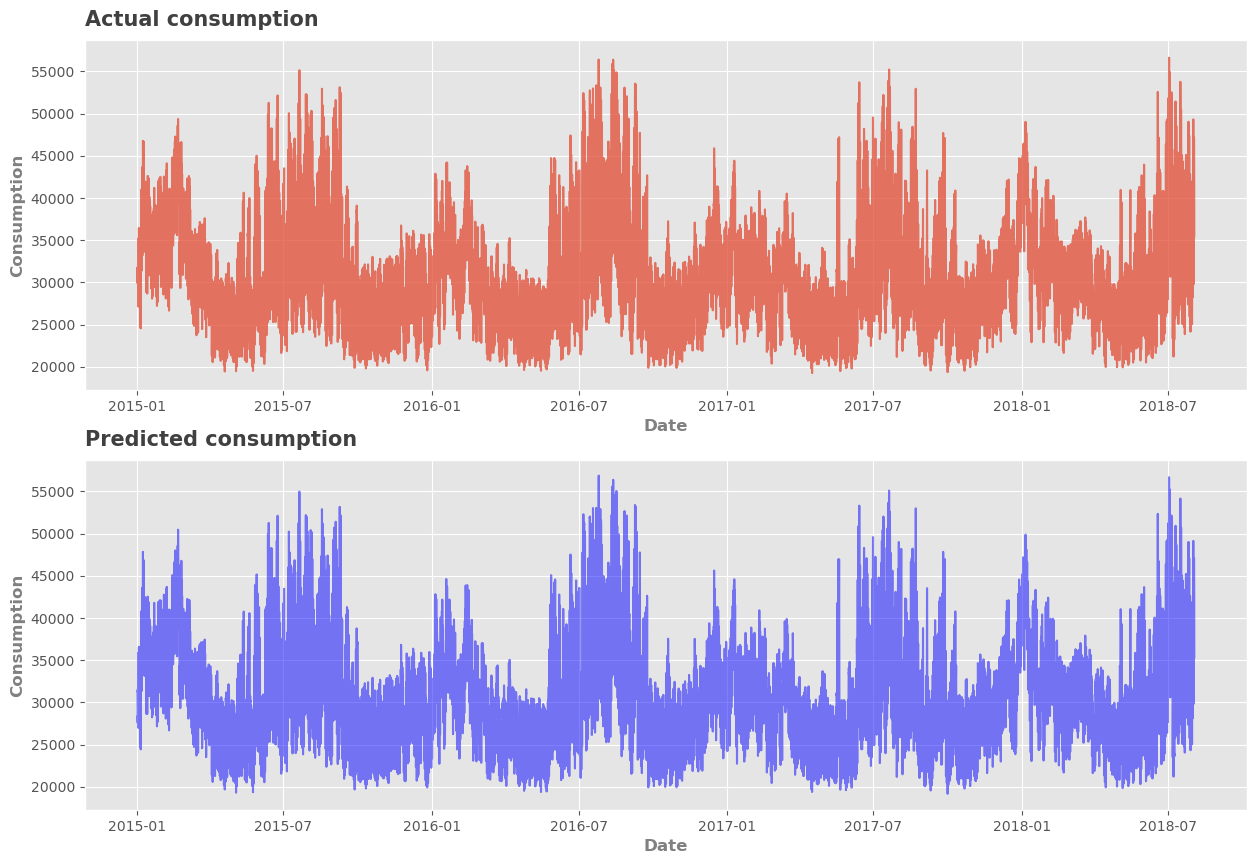

In [23]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharey=True)

ax1.plot(consum_test.index,consum_test["PJME_MW"],alpha=0.75)
ax2.plot(consum_test.index,consum_test["Prediction"],color="blue",alpha=0.50)

ax1.set_xlabel("Date", alpha=0.75, weight="bold")
ax1.set_ylabel("Consumption", alpha=0.75, weight="bold")
ax2.set_xlabel("Date", alpha=0.75, weight="bold")
ax2.set_ylabel("Consumption", alpha=0.75, weight="bold")

ax1.set_title("Actual consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
ax2.set_title("Predicted consumption", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

The actual consumption is again covered by the predicted consumption. We have to resort to evaluation metrics.

In [24]:
mean_sq = mean_squared_error(y_test,xgd_reg.predict(X_test))
rmse = np.sqrt(mean_sq)

mean_abs_sq = mean_absolute_error(y_test,xgd_reg.predict(X_test))

print("Root Mean Squared Error : {}".format(rmse))
print("Mean Absolute Error : {}".format(mean_abs_sq))

Root Mean Squared Error : 450.3890111423055
Mean Absolute Error : 270.7687638510693


In [25]:
# Worst Hour Prediction
consum_test["Difference"] = np.abs(consum_test["PJME_MW"] - consum_test["Prediction"])
consum_test["Difference"].sort_values(ascending=False)[:10]

Datetime
2016-07-18 18:00:00    4927.589844
2018-07-17 17:00:00    4746.210938
2018-01-18 13:00:00    4103.566406
2018-01-18 12:00:00    3878.679688
2018-02-27 12:00:00    3653.507812
2016-01-06 11:00:00    3636.562500
2018-01-04 12:00:00    3632.285156
2017-06-19 18:00:00    3627.402344
2018-02-27 13:00:00    3621.826172
2016-01-06 12:00:00    3616.039062
Name: Difference, dtype: float64

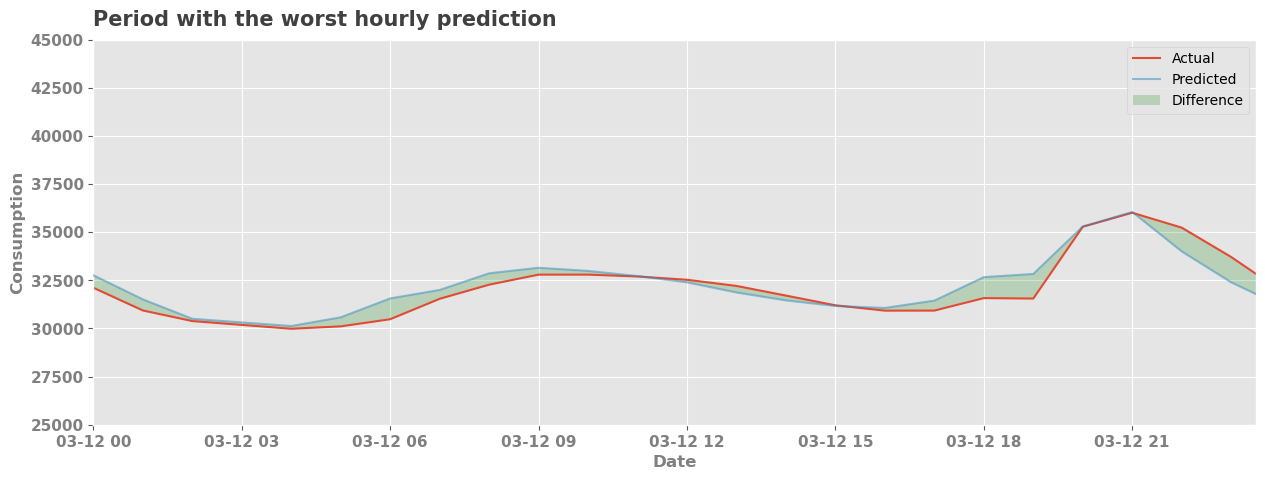

In [26]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(consum_test.index, consum_test["PJME_MW"], label="Actual")
ax.plot(consum_test.index, consum_test["Prediction"], alpha=0.5, zorder=10, label="Predicted")

consum = consum_test["PJME_MW"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum, pred, facecolor="green", alpha=0.2, label="Difference")

ax.set_ylim(25000, 45000)

lower_limit = datetime.strptime("2017-03-12 00:00:00", "%Y-%m-%d %H:%M:%S")
upper_limit = datetime.strptime("2017-03-12 23:30:00", "%Y-%m-%d %H:%M:%S")
ax.set_xlim(lower_limit, upper_limit)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75, weight="bold", fontsize=11)
plt.yticks(alpha=0.75, weight="bold", fontsize=11)

plt.title("Period with the worst hourly prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
plt.legend()

plt.show()


In [27]:
#Worst Days
worst_days = consum_test.groupby(['Year','Month','Dayofmonth']).mean()[['PJME_MW','Prediction','Difference']]
worst_days.sort_values(by="Difference",ascending=False)[:10]

,,,PJME_MW,Prediction,Difference
Year,Month,Dayofmonth,,,
2015,2,20,44694.041667,45335.527344,1213.169922
2017,12,31,39016.000000,37885.406250,1173.572917
2015,2,15,40795.875000,39996.656250,1010.373372
2016,1,6,36636.791667,37307.460938,976.869303
2015,2,24,41002.166667,41610.171875,943.207845
2018,1,31,37180.125000,37964.566406,933.077311
2015,1,1,31720.521739,31032.017578,913.205248
2018,2,27,29694.041667,30342.425781,908.983398
2017,3,23,32248.208333,32964.050781,882.091715


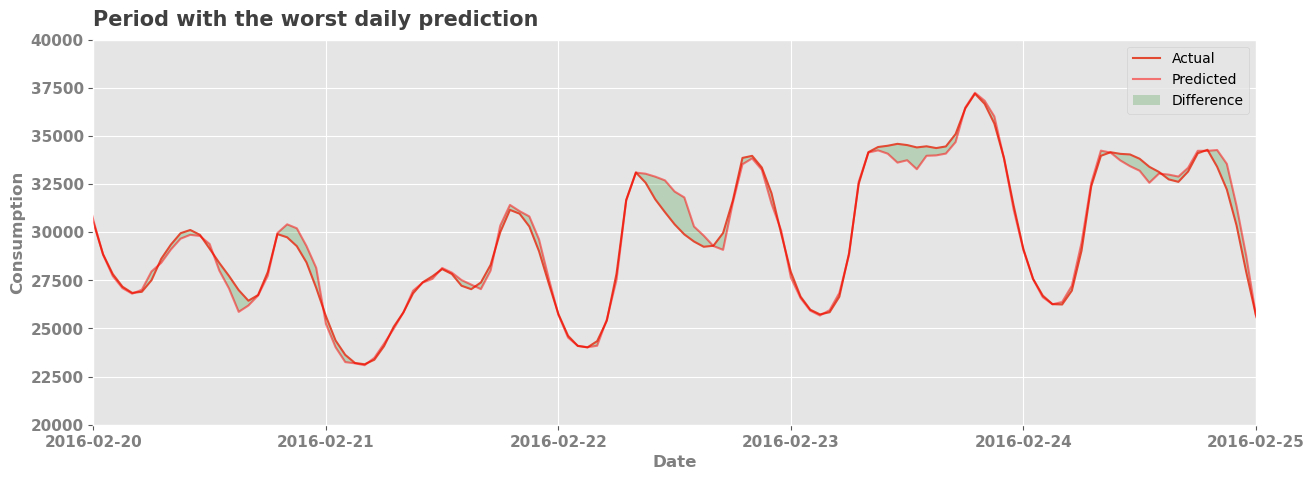

In [28]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(consum_test.index, consum_test["PJME_MW"], label="Actual")
ax.plot(consum_test.index, consum_test["Prediction"], color="red", alpha=0.5, zorder=10, label="Predicted")

consum = consum_test["PJME_MW"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum, pred, facecolor="green", alpha=0.2, label="Difference")

ax.set_ylim(20000, 40000)

lower_limit = datetime.strptime("2016-02-20", "%Y-%m-%d")
upper_limit = datetime.strptime("2016-02-25", "%Y-%m-%d")
ax.set_xlim(lower_limit, upper_limit)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75, weight="bold", fontsize=11)
plt.yticks(alpha=0.75, weight="bold", fontsize=11)

plt.title("Period with the worst daily prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

ax.legend()

plt.show()


In [29]:
#Best Days
worst_days.sort_values(by="Difference",ascending=True)[:10]

PJME_MW    Prediction  Difference
Year Month Dayofmonth                                        
2015 9     14          27921.041667  27921.207031   50.313070
     10    8           27414.541667  27418.425781   71.561198
2016 5     24          27713.375000  27688.666016   73.778320
     10    2           24659.083333  24691.044922   74.367513
     9     28          27910.833333  27945.945312   74.579753
2015 10    7           27375.041667  27360.136719   74.819499
     9     21          27988.041667  27954.718750   75.780273
2017 8     30          29246.166667  29263.183594   76.689209
2016 10    13          26975.125000  27012.021484   77.353597
2017 5     7           23493.041667  23502.316406   78.180420

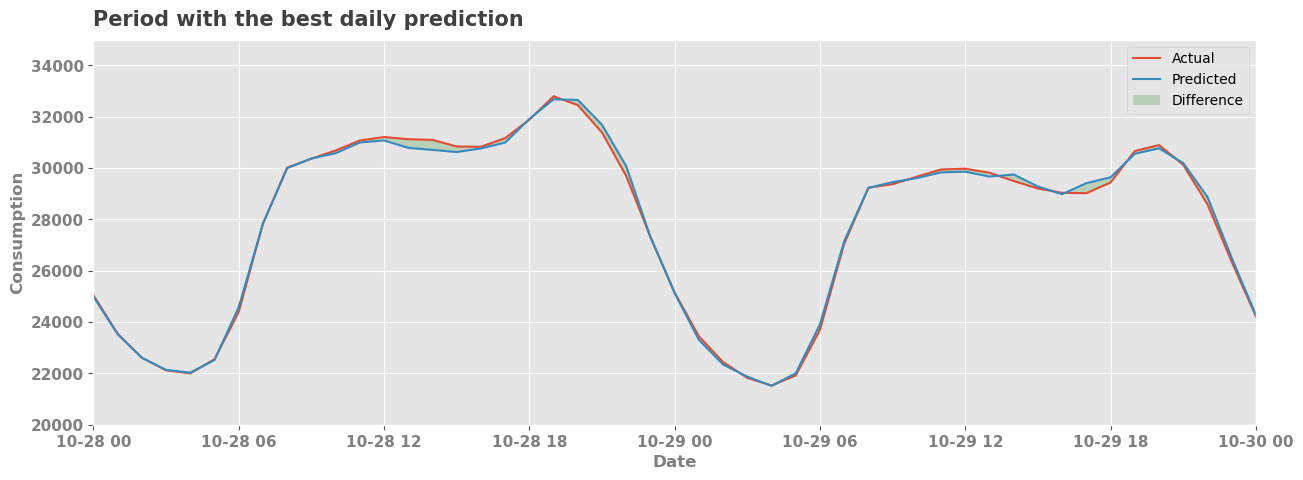

In [30]:
import matplotlib.pyplot as plt
from datetime import datetime

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(consum_test.index, consum_test["PJME_MW"], label="Actual")
ax.plot(consum_test.index, consum_test["Prediction"], label="Predicted")
consum = consum_test["PJME_MW"]
pred = consum_test["Prediction"]

plt.fill_between(consum_test.index, consum, pred, facecolor="green", alpha=0.2, label="Difference")

ax.set_ylim(20000, 35000)

lower_limit = datetime.strptime("2015-10-28", "%Y-%m-%d")
upper_limit = datetime.strptime("2015-10-30", "%Y-%m-%d")
ax.set_xlim(lower_limit, upper_limit)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Consumption", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75, weight="bold", fontsize=11)
plt.yticks(alpha=0.75, weight="bold", fontsize=11)

plt.title("Period with the best daily prediction", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

ax.legend()

plt.show()
